# Simple CNN Model for Malaria Image Detection
+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-

![Malario](https://images3.memedroid.com/images/UPLOADED68/5c6b111fb1011.jpeg)

# 1.1 Data Preproc



1.1.1 Pseudo-Code

---

1. EDA 
2. Preproc Pipeline
3. Model Pipeline
4. Combine Pipeline
5. Train model on subset

---

In [28]:
from google.colab import drive

drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [1]:
# imports 

import pandas as pd 
import numpy as np
import imageio as im
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
from tensorflow.keras import layers

/Users/henryschrader/.pyenv/versions/3.8.12/envs/lewagon/lib/python3.8/site-packages/pandas/compat/__init__.py:124: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)


## 1.2 EDA (lite)

In [2]:
raw_data_dir = "../raw_data/malaria/cell_images"

os.listdir(raw_data_dir)

['.DS_Store', 'Parasitized', 'Uninfected']

In [214]:
parasitized = os.listdir(f"{raw_data_dir}/Parasitized")
uninfected = os.listdir(f"{raw_data_dir}/Uninfected")

# I know its hardcoded ...

In [215]:
parasitized[1]

'C189P150ThinF_IMG_20151203_142224_cell_84.png'

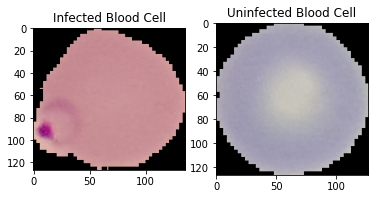

In [216]:
im1 = mpimg.imread(f"{raw_data_dir}/Parasitized/{parasitized[5]}")
im2 = mpimg.imread(f"{raw_data_dir}/Uninfected/{uninfected[5]}")
plt.subplot(1,2,1)
plt.imshow(im1)
plt.title("Infected Blood Cell")
plt.subplot(1,2,2)
plt.imshow(im2)
plt.title("Uninfected Blood Cell");

In [217]:
print(len(parasitized))
print("+---+")
print(len(uninfected))
print("+---+")
print(f"Ratio:{len(parasitized)/len(uninfected)}")

13781
+---+
13780
+---+
Ratio:1.0000725689404935


Dataset is balanced (Keep in mind, that in real life the ratio variates, but can be approximated with 1/1)

## 1.3 Dataset Creation and Split

In [80]:
from tensorflow.keras.utils import image_dataset_from_directory

batch_size = 16
height = 128
width = 128

data_train = image_dataset_from_directory(raw_data_dir, batch_size=batch_size, label_mode="binary", color_mode="grayscale", validation_split=0.2,image_size=(height, width), seed=42, subset="training")

data_val = image_dataset_from_directory(raw_data_dir, batch_size=batch_size,label_mode="binary", color_mode="grayscale", validation_split=0.2, image_size=(height, width), seed=42, subset="validation")

Found 27558 files belonging to 2 classes.
Using 22047 files for training.
Found 27558 files belonging to 2 classes.
Using 5511 files for validation.


In [81]:
class_names = data_train.class_names

In [ ]:
plt.figure(figsize=(10, 10))
for images, labels in data_train.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

# 2 Modeling

---

## 2.1 Baseline model

In [44]:
# Since the Dataset is balanced a baseline model would be guess one class on a 50% probabiity

base_acc = 0.5

# Model needs to beat 0.5 acc

## 2.2 Simple CNN Model

In [83]:
from tensorflow.keras import Sequential

model = Sequential()
model.add(layers.Rescaling(1/255,input_shape=(128,128,1)))
model.add(layers.Conv2D(16,(3,3),activation='relu'))
model.add(layers.MaxPool2D(2,2))
model.add(layers.Dropout(0.2))

model.add(layers.Conv2D(32,(3,3),activation='relu'))
model.add(layers.MaxPool2D(2,2))
model.add(layers.Dropout(0.3))

model.add(layers.Conv2D(64,(3,3),activation='relu'))
model.add(layers.MaxPool2D(2,2))
model.add(layers.Dropout(0.3))

model.add(layers.Flatten())
model.add(layers.Dense(64,activation='relu'))
model.add(layers.Dropout(0.5))

model.add(layers.Dense(1,activation='sigmoid'))

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 128, 128, 1)       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 126, 126, 16)      160       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 63, 63, 16)       0         
 2D)                                                             
                                                                 
 dropout_4 (Dropout)         (None, 63, 63, 16)        0         
                                                                 
 conv2d_4 (Conv2D)           (None, 61, 61, 32)        4640      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 30, 30, 32)       0         
 2D)                                                  

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping

model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["Accuracy","Recall"])

es = EarlyStopping(patience=5, restore_best_weights=True)

history = model.fit(data_train, validation_data=data_val, epochs=1, verbose=1, callbacks=es)

In [58]:
def plotLearningCurve(history):
    plt.plot(history.history['Accuracy'])
    plt.plot(history.history['val_Accuracy'])
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(['Train','Validation'],loc='upper left')
    plt.show()

    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(['Train','Validation'],loc='upper left')
    plt.show()

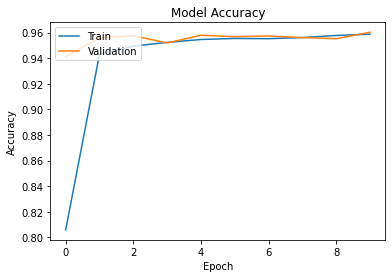

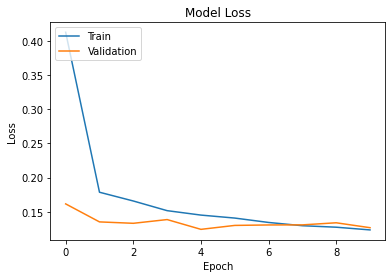

In [60]:
plotLearningCurve(history)

In [15]:
from tensorflow.keras.utils import img_to_array, load_img

In [16]:
X_pred = mpimg.imread("../raw_data/malaria/cell_images/Parasitized/C33P1thinF_IMG_20150619_120838a_cell_222.png")

In [17]:
X_pred.shape

(148, 145, 3)

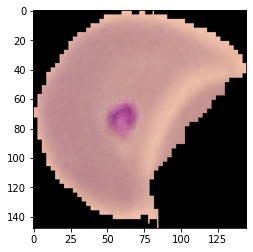

In [18]:
plt.imshow(X_pred);

In [19]:
from tensorflow.image import resize

X_pred = resize(X_pred, (128,128))
#X_pred = np.reshape(X_pred, (1,128,128,3))

In [20]:
X_pred.shape

TensorShape([128, 128, 3])

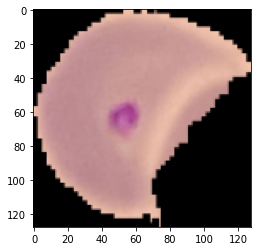

In [21]:
plt.imshow(X_pred);

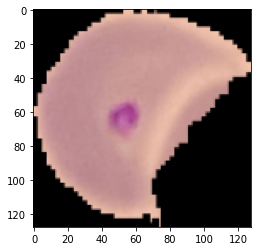

In [22]:
X_pred = np.reshape(X_pred,(1,128,128,3))
plt.imshow(X_pred[0]);

In [58]:
from tensorflow import expand_dims
from tensorflow.keras.utils import load_img, img_to_array


In [59]:
get_data().shape

(15, 128, 128, 3)

In [1]:
import pandas as pd 
import numpy as np
import imageio as im
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
from tensorflow.keras import layers

/Users/henryschrader/.pyenv/versions/3.8.12/envs/lewagon/lib/python3.8/site-packages/pandas/compat/__init__.py:124: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)


In [2]:
from BloodCellAnalyzer import data, rbc_seg
from BloodCellAnalyzer import models

creator = models.malaria()

creator.create_model("henry")

2021-12-09 11:20:27.905458: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
creator.model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_3 (Rescaling)     (None, 128, 128, 1)       0         
                                                                 
 conv2d_20 (Conv2D)          (None, 126, 126, 16)      160       
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 63, 63, 16)       0         
 2D)                                                             
                                                                 
 dropout_32 (Dropout)        (None, 63, 63, 16)        0         
                                                                 
 conv2d_21 (Conv2D)          (None, 61, 61, 32)        4640      
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 30, 30, 32)       0         
 2D)                                                  

In [4]:
pred = creator.predict("../raw_data/malaria-parasite-infecting-red-blood-cells_1600x1200.jpg")
pred 

,Proba of Inf(%),Status
0,0.99,Uninfected
1,0.99,Uninfected
2,0.99,Uninfected
3,0.99,Uninfected
4,0.99,Uninfected
...,...,...
83,0.99,Uninfected
84,0.11,Infected
85,0.99,Uninfected
86,0.00,Infected


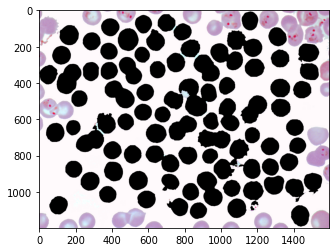

In [5]:
plt.imshow(creator.img)

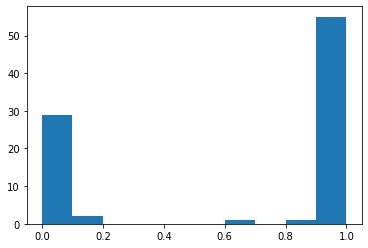

In [6]:
plt.hist(pred["Proba of Inf(%)"]);

In [6]:
tmp_im = mpimg.imread("../rhistplotata/malaria-parasite-infecting-red-blood-cells_1600x1200.jpg")

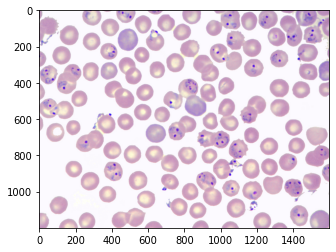

In [7]:
plt.imshow(tmp_im);